In [1]:
import sqlite3
import pandas as pd
import numpy as np

In [2]:
con = sqlite3.connect("FPA_FOD_20170508.sqlite")

In [3]:
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('spatial_ref_sys',), ('spatialite_history',), ('sqlite_sequence',), ('geometry_columns',), ('spatial_ref_sys_aux',), ('views_geometry_columns',), ('virts_geometry_columns',), ('geometry_columns_statistics',), ('views_geometry_columns_statistics',), ('virts_geometry_columns_statistics',), ('geometry_columns_field_infos',), ('views_geometry_columns_field_infos',), ('virts_geometry_columns_field_infos',), ('geometry_columns_time',), ('geometry_columns_auth',), ('views_geometry_columns_auth',), ('virts_geometry_columns_auth',), ('sql_statements_log',), ('SpatialIndex',), ('ElementaryGeometries',), ('KNN',), ('Fires',), ('idx_Fires_Shape',), ('idx_Fires_Shape_node',), ('idx_Fires_Shape_rowid',), ('idx_Fires_Shape_parent',), ('NWCG_UnitIDActive_20170109',)]


In [4]:
wildfires = pd.read_sql_query("SELECT * from Fires", con)

Lets take a look at the columns of the original data:

In [5]:
wildfires.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

Now create a separate dataframe with just the columns we want:

In [6]:
fires = wildfires[["FOD_ID", "NWCG_REPORTING_UNIT_ID", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","CONT_DOY","FIRE_SIZE","FIRE_SIZE_CLASS","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]

In [7]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE
0,1,USCAPNF,2005,33,9.0,33.0,0.10,A,40.036944,-121.005833,5.0,CA
1,2,USCAENF,2004,133,1.0,133.0,0.25,A,38.933056,-120.404444,5.0,CA
2,3,USCAENF,2004,152,5.0,152.0,0.10,A,38.984167,-120.735556,13.0,CA
3,4,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.913333,5.0,CA
4,5,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.933056,5.0,CA


In [8]:
fires.shape

(1880465, 12)

Look at original correlation matrix:

In [9]:
corrMatrix = fires.corr()

In [10]:
import seaborn as sn
import matplotlib.pyplot as plt

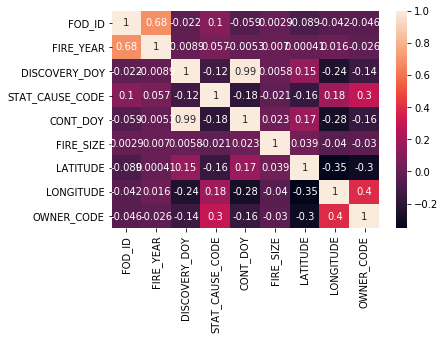

In [11]:
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [12]:
fires.dtypes

FOD_ID                      int64
NWCG_REPORTING_UNIT_ID     object
FIRE_YEAR                   int64
DISCOVERY_DOY               int64
STAT_CAUSE_CODE           float64
CONT_DOY                  float64
FIRE_SIZE                 float64
FIRE_SIZE_CLASS            object
LATITUDE                  float64
LONGITUDE                 float64
OWNER_CODE                float64
STATE                      object
dtype: object

Start by clustering based on fire size and compare their number of classes to the 'optimal' number found:

In [13]:
from sklearn.cluster import KMeans

In [14]:
# k means based on size of fires

In [15]:
sizes = fires.loc[:,['FOD_ID','FIRE_SIZE']]

In [16]:
sizes.head()

,FOD_ID,FIRE_SIZE
0,1,0.10
1,2,0.25
2,3,0.10
3,4,0.10
4,5,0.10


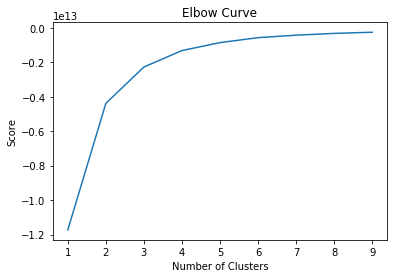

In [17]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = fires[['FIRE_SIZE']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Based on the elbow curve, lets take 3 as our number of optimal clusters

In [18]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(sizes[sizes.columns[1:2]]) 
# Compute k-means clustering.
sizes['cluster_label'] = kmeans.fit_predict(sizes[sizes.columns[1:2]])
centers = kmeans.cluster_centers_ 
# Coordinates of cluster centers.
labels = kmeans.predict(sizes[sizes.columns[1:2]]) 
# Labels of each point
sizes.head(10)

,FOD_ID,FIRE_SIZE,cluster_label
0,1,0.10,0
1,2,0.25,0
2,3,0.10,0
3,4,0.10,0
4,5,0.10,0
5,6,0.10,0
6,7,0.10,0
7,8,0.80,0
8,9,1.00,0
9,10,0.10,0


In [19]:
centers

array([[4.00992752e+01],
       [2.89765451e+05],
       [7.06198230e+04]])

In [20]:
sizes.FIRE_SIZE.describe()

count    1.880465e+06
mean     7.452016e+01
std      2.497598e+03
min      1.000000e-05
25%      1.000000e-01
50%      1.000000e+00
75%      3.300000e+00
max      6.069450e+05
Name: FIRE_SIZE, dtype: float64

Now lets do a clustering based on location.

In [21]:
locations = fires.loc[:,['FOD_ID','LATITUDE','LONGITUDE']]

In [22]:
locations.head()

,FOD_ID,LATITUDE,LONGITUDE
0,1,40.036944,-121.005833
1,2,38.933056,-120.404444
2,3,38.984167,-120.735556
3,4,38.559167,-119.913333
4,5,38.559167,-119.933056


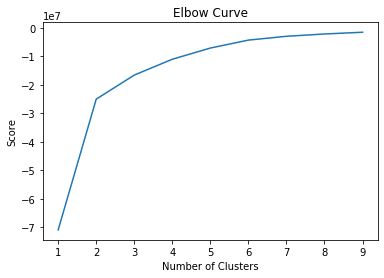

In [23]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = fires[['LATITUDE']]
X_axis = fires[['LONGITUDE']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Based on the elbow curve we can do 4 clusters.

In [24]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(locations[locations.columns[1:3]]) 
# Compute k-means clustering.
locations['cluster_label'] = kmeans.fit_predict(locations[locations.columns[1:3]])
centers = kmeans.cluster_centers_ 
# Coordinates of cluster centers.
labels = kmeans.predict(locations[locations.columns[1:3]]) 
# Labels of each point
locations.head(10)

,FOD_ID,LATITUDE,LONGITUDE,cluster_label
0,1,40.036944,-121.005833,1
1,2,38.933056,-120.404444,1
2,3,38.984167,-120.735556,1
3,4,38.559167,-119.913333,1
4,5,38.559167,-119.933056,1
5,6,38.635278,-120.103611,1
6,7,38.688333,-120.153333,1
7,8,40.968056,-122.433889,1
8,9,41.233611,-122.283333,1
9,10,38.548333,-120.149167,1


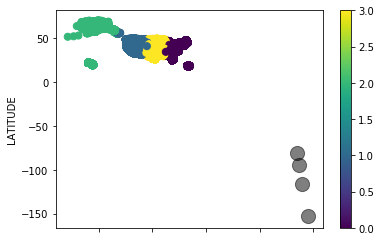

In [25]:
locations.plot.scatter(x = 'LONGITUDE', y = 'LATITUDE', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

The above map does look like the United States.

In [26]:
locations = locations[['FOD_ID','cluster_label']]

merge clustered locations back in and look at new cluster labels:

In [27]:
new_wildfires = fires.merge(locations, left_on='FOD_ID', right_on='FOD_ID')

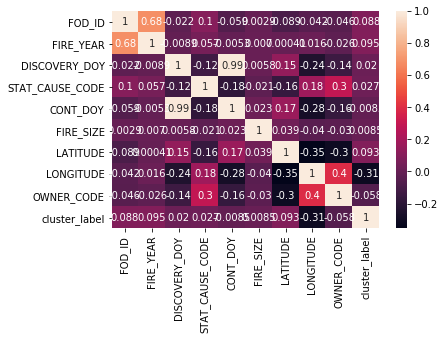

In [28]:
new_corrMatrix = new_wildfires.corr()
sn.heatmap(new_corrMatrix, annot=True)
plt.show()

In [29]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE
0,1,USCAPNF,2005,33,9.0,33.0,0.10,A,40.036944,-121.005833,5.0,CA
1,2,USCAENF,2004,133,1.0,133.0,0.25,A,38.933056,-120.404444,5.0,CA
2,3,USCAENF,2004,152,5.0,152.0,0.10,A,38.984167,-120.735556,13.0,CA
3,4,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.913333,5.0,CA
4,5,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.933056,5.0,CA


Date helper function.

In [30]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

In [31]:
fires["NEW_DISC_DATE"] = compose_date(fires['FIRE_YEAR'], days=fires['DISCOVERY_DOY'])

C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
fires.loc[fires['CONT_DOY'] < fires['DISCOVERY_DOY'], 'different_years'] = 1
fires.loc[fires['CONT_DOY'] >= fires['DISCOVERY_DOY'], 'different_years'] = 0

C:\Users\Sam\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Sam\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [33]:
fires["NEW_CONT_DATE"] = compose_date(fires['FIRE_YEAR'] + fires['different_years'], days = fires["CONT_DOY"])

C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE,NEW_DISC_DATE,different_years,NEW_CONT_DATE
0,1,USCAPNF,2005,33,9.0,33.0,0.10,A,40.036944,-121.005833,5.0,CA,2005-02-02,0.0,2005-02-02
1,2,USCAENF,2004,133,1.0,133.0,0.25,A,38.933056,-120.404444,5.0,CA,2004-05-12,0.0,2004-05-12
2,3,USCAENF,2004,152,5.0,152.0,0.10,A,38.984167,-120.735556,13.0,CA,2004-05-31,0.0,2004-05-31
3,4,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.913333,5.0,CA,2004-06-28,0.0,2004-07-03
4,5,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.933056,5.0,CA,2004-06-28,0.0,2004-07-03


In [35]:
fires["CONT_TIME"] = (fires["NEW_CONT_DATE"] - fires["NEW_DISC_DATE"]).dt.days

C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE,NEW_DISC_DATE,different_years,NEW_CONT_DATE,CONT_TIME
0,1,USCAPNF,2005,33,9.0,33.0,0.10,A,40.036944,-121.005833,5.0,CA,2005-02-02,0.0,2005-02-02,0.0
1,2,USCAENF,2004,133,1.0,133.0,0.25,A,38.933056,-120.404444,5.0,CA,2004-05-12,0.0,2004-05-12,0.0
2,3,USCAENF,2004,152,5.0,152.0,0.10,A,38.984167,-120.735556,13.0,CA,2004-05-31,0.0,2004-05-31,0.0
3,4,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.913333,5.0,CA,2004-06-28,0.0,2004-07-03,5.0
4,5,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.933056,5.0,CA,2004-06-28,0.0,2004-07-03,5.0


In [37]:
fires.CONT_TIME.describe()

count    988934.000000
mean          1.142863
std           8.304796
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         365.000000
Name: CONT_TIME, dtype: float64

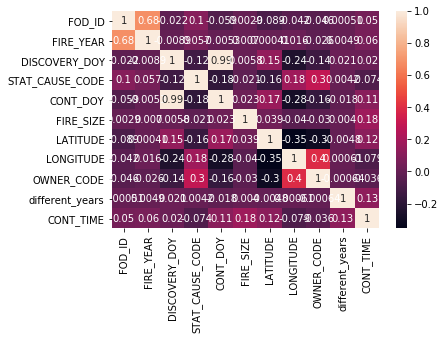

In [38]:
new_corrMatrix = fires.corr()
sn.heatmap(new_corrMatrix, annot=True)
plt.show()

In [39]:
fires.different_years.describe()

count    988934.000000
mean          0.000145
std           0.012024
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: different_years, dtype: float64

In [40]:
from yellowbrick.features import Rank1D

C:\Users\Sam\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [41]:
X = wildfires[["FOD_ID", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","OWNER_CODE"]]
y = wildfires["FIRE_SIZE"]

C:\Users\Sam\anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


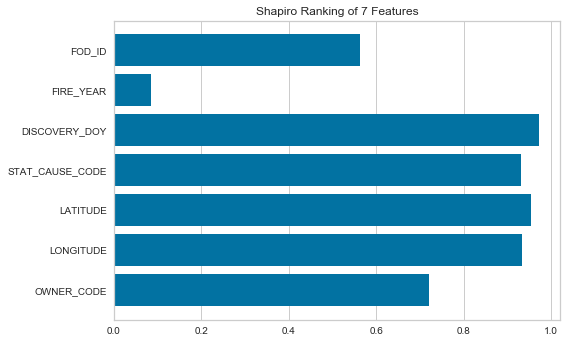

In [42]:
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show() 

In [43]:
fires.head()

,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE,NEW_DISC_DATE,different_years,NEW_CONT_DATE,CONT_TIME
0,1,USCAPNF,2005,33,9.0,33.0,0.10,A,40.036944,-121.005833,5.0,CA,2005-02-02,0.0,2005-02-02,0.0
1,2,USCAENF,2004,133,1.0,133.0,0.25,A,38.933056,-120.404444,5.0,CA,2004-05-12,0.0,2004-05-12,0.0
2,3,USCAENF,2004,152,5.0,152.0,0.10,A,38.984167,-120.735556,13.0,CA,2004-05-31,0.0,2004-05-31,0.0
3,4,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.913333,5.0,CA,2004-06-28,0.0,2004-07-03,5.0
4,5,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.933056,5.0,CA,2004-06-28,0.0,2004-07-03,5.0


In [44]:
wildfires.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [45]:
fires.head()


,FOD_ID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,STATE,NEW_DISC_DATE,different_years,NEW_CONT_DATE,CONT_TIME
0,1,USCAPNF,2005,33,9.0,33.0,0.10,A,40.036944,-121.005833,5.0,CA,2005-02-02,0.0,2005-02-02,0.0
1,2,USCAENF,2004,133,1.0,133.0,0.25,A,38.933056,-120.404444,5.0,CA,2004-05-12,0.0,2004-05-12,0.0
2,3,USCAENF,2004,152,5.0,152.0,0.10,A,38.984167,-120.735556,13.0,CA,2004-05-31,0.0,2004-05-31,0.0
3,4,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.913333,5.0,CA,2004-06-28,0.0,2004-07-03,5.0
4,5,USCAENF,2004,180,1.0,185.0,0.10,A,38.559167,-119.933056,5.0,CA,2004-06-28,0.0,2004-07-03,5.0


In [46]:

fires3 = wildfires.apply(lambda col: pd.factorize(col, sort=True)[0])
fires2 = wildfires.apply(lambda col: pd.factorize(col, sort=True)[0])[["FOD_ID", "NWCG_REPORTING_UNIT_ID", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","CONT_DOY","FIRE_SIZE","FIRE_SIZE_CLASS","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]

In [47]:
wildfires.head()
fires2.head()
fires3.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,0,0,181593,0,2,5,221,1168,194,3206,...,0,606034,70162,5,15,4,199,38,1213,1428664
1,1,1,181594,0,2,5,174,453,186,1257,...,0,575264,83257,5,15,4,197,37,1210,527209
2,2,2,181598,0,2,5,174,453,186,1257,...,0,576636,76224,13,12,4,100,10,499,1282382
3,3,3,181604,0,2,5,174,453,186,1257,...,0,564469,89798,5,15,4,151,1,28,914951
4,4,4,181605,0,2,5,174,453,186,1257,...,0,564469,89617,5,15,4,151,1,28,406898


In [48]:
X = fires2[["FOD_ID", "NWCG_REPORTING_UNIT_ID", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","CONT_DOY","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]
y = fires2[["FIRE_SIZE"]]

C:\Users\Sam\anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


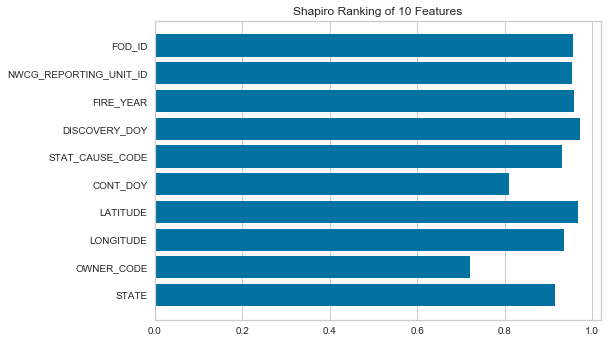

In [49]:
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show() 

In [50]:
CATEGORICAL = ["NWCG_REPORTING_AGENCY", "FIRE_SIZE_CLASS", "STATE"]
NUMERICAL = ['DISCOVERY_TIME',"FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE", "CONT_DOY", "FIRE_SIZE", "LATITUDE", "LONGITUDE", "OWNER_CODE"]



In [51]:
fires_table = pd.read_sql_query("SELECT * from Fires", con)

In [52]:
wildfires = fires_table[NUMERICAL + CATEGORICAL]

In [53]:
wildfires.head()

,DISCOVERY_TIME,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_CODE,NWCG_REPORTING_AGENCY,FIRE_SIZE_CLASS,STATE
0,1300,2005,33,9.0,33.0,0.10,40.036944,-121.005833,5.0,FS,A,CA
1,0845,2004,133,1.0,133.0,0.25,38.933056,-120.404444,5.0,FS,A,CA
2,1921,2004,152,5.0,152.0,0.10,38.984167,-120.735556,13.0,FS,A,CA
3,1600,2004,180,1.0,185.0,0.10,38.559167,-119.913333,5.0,FS,A,CA
4,1600,2004,180,1.0,185.0,0.10,38.559167,-119.933056,5.0,FS,A,CA


In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sqlite3
from sqlalchemy import create_engine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [55]:
le = preprocessing.LabelEncoder()
le.fit(wildfires["STATE"].unique())
wildfires.loc[:, "STATE"] = le.transform(wildfires["STATE"])
le.fit(wildfires["NWCG_REPORTING_AGENCY"].unique())
wildfires.loc[:, "NWCG_REPORTING_AGENCY"] = le.transform(wildfires["NWCG_REPORTING_AGENCY"])
le.fit(wildfires["FIRE_SIZE_CLASS"].unique())
wildfires.loc[:, "FIRE_SIZE_CLASS"] = le.transform(wildfires["FIRE_SIZE_CLASS"])


C:\Users\Sam\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [56]:
wildfires.head()

,DISCOVERY_TIME,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_CODE,NWCG_REPORTING_AGENCY,FIRE_SIZE_CLASS,STATE
0,1300,2005,33,9.0,33.0,0.10,40.036944,-121.005833,5.0,5,0,4
1,0845,2004,133,1.0,133.0,0.25,38.933056,-120.404444,5.0,5,0,4
2,1921,2004,152,5.0,152.0,0.10,38.984167,-120.735556,13.0,5,0,4
3,1600,2004,180,1.0,185.0,0.10,38.559167,-119.913333,5.0,5,0,4
4,1600,2004,180,1.0,185.0,0.10,38.559167,-119.933056,5.0,5,0,4


In [57]:
X = wildfires[["NWCG_REPORTING_AGENCY", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","CONT_DOY","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]
y = wildfires["FIRE_SIZE"]

C:\Users\Sam\anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


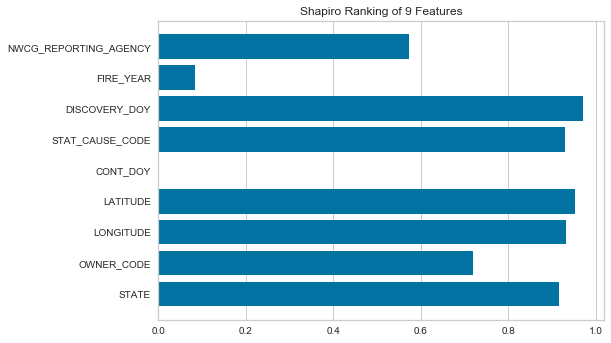

In [58]:
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show() 

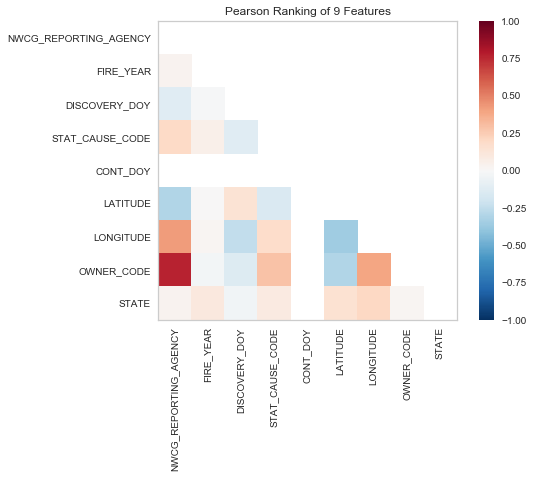

In [59]:
from yellowbrick.features import Rank2D


visualizer = Rank2D(algorithm='pearson')

visualizer.fit(X, y)           
visualizer.transform(X)        
visualizer.show()  

In [60]:
wildfires2= wildfires.sample(frac=.15, replace=False, weights=None, random_state=2)
wildfires2.reset_index(drop=True, inplace=True)

X2= wildfires2[["DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","STATE"]]
y2 = wildfires2["FIRE_SIZE_CLASS"]
wildfires2.shape

(282070, 12)

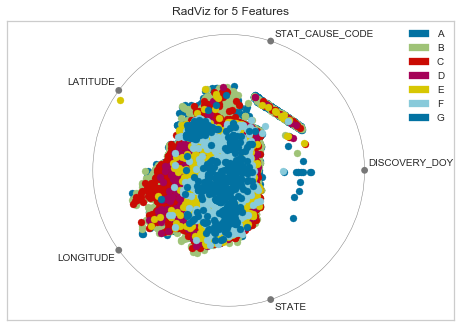

In [61]:
from yellowbrick.features import RadViz


classes = ["A", "B", "C", "D", "E","F", "G"]
# Instantiate the visualizer
visualizer = RadViz(classes = classes)

visualizer.fit(X2, y2)           # Fit the data to the visualizer
visualizer.transform(X2)        # Transform the data
visualizer.show()      

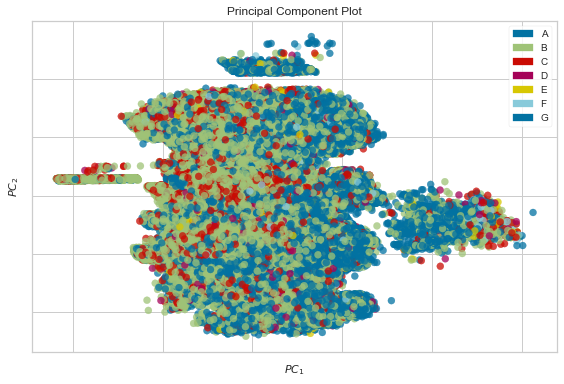

In [62]:
from yellowbrick.features import PCA

# Specify the features of interest and the target
classes = ["A", "B", "C", "D", "E","F", "G"]

visualizer = PCA(scale=True, classes=classes)
visualizer.fit_transform(X2, y2)
visualizer.show()

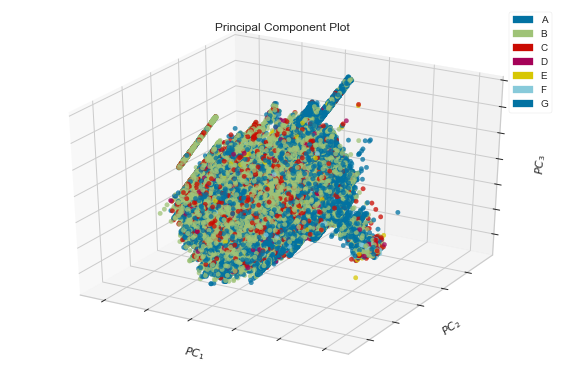

In [63]:
from yellowbrick.features import PCA


classes = ["A", "B", "C", "D", "E","F", "G"]

visualizer = PCA(
    scale=True, projection=3, classes=classes
)
visualizer.fit_transform(X2, y2)
visualizer.show()

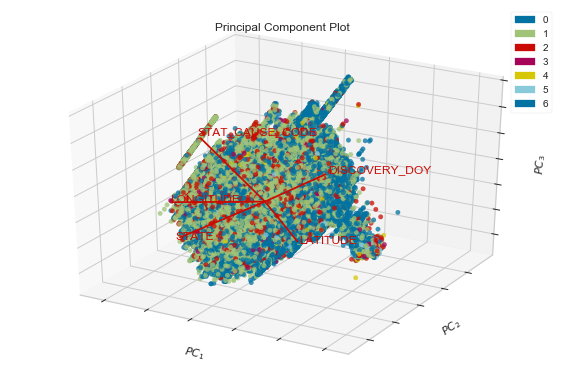

In [64]:
visualizer = PCA(scale=True, proj_features=True, projection=3)
visualizer.fit_transform(X2, y2)
visualizer.show()

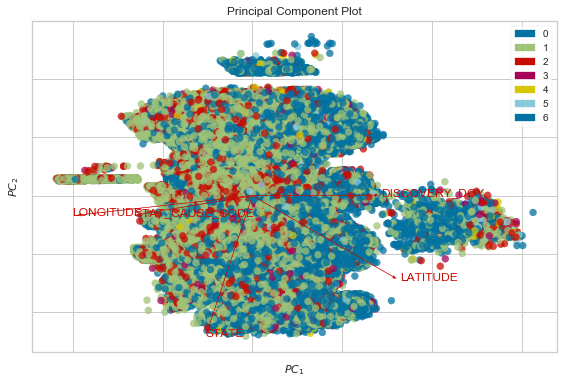

In [65]:
visualizer = PCA(scale=True, proj_features=True)
visualizer.fit_transform(X2, y2)
visualizer.show()

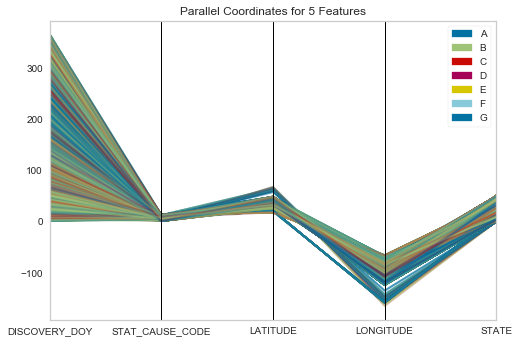

In [66]:
from yellowbrick.features import ParallelCoordinates

# Specify the features of interest and the classes of the target
features = [
    "DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","STATE"]
classes = ["A", "B", "C", "D", "E","F", "G"]

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features, sample=0.05, shuffle=True
)

# Fit and transform the data to the visualizer
visualizer.fit_transform(X2,y2)

# Finalize the title and axes then display the visualization
visualizer.show()

In [67]:
CATEGORICAL = ["NWCG_REPORTING_AGENCY", "FIRE_SIZE_CLASS", "STATE"]
NUMERICAL = ['DISCOVERY_TIME',"FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE", "CONT_DOY", "FIRE_SIZE", "LATITUDE", "LONGITUDE", "OWNER_CODE"]
fires_table = pd.read_sql_query("SELECT * from Fires where FIRE_SIZE>= 100", con)
wildfires = fires_table[NUMERICAL + CATEGORICAL]

In [68]:
le = preprocessing.LabelEncoder()
le.fit(wildfires["STATE"].unique())
wildfires.loc[:, "STATE"] = le.transform(wildfires["STATE"])
le.fit(wildfires["NWCG_REPORTING_AGENCY"].unique())
wildfires.loc[:, "NWCG_REPORTING_AGENCY"] = le.transform(wildfires["NWCG_REPORTING_AGENCY"])
le.fit(wildfires["FIRE_SIZE_CLASS"].unique())
wildfires.loc[:, "FIRE_SIZE_CLASS"] = le.transform(wildfires["FIRE_SIZE_CLASS"])
X = wildfires[["NWCG_REPORTING_AGENCY", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","CONT_DOY","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]
y = wildfires["FIRE_SIZE"]

C:\Users\Sam\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


C:\Users\Sam\anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


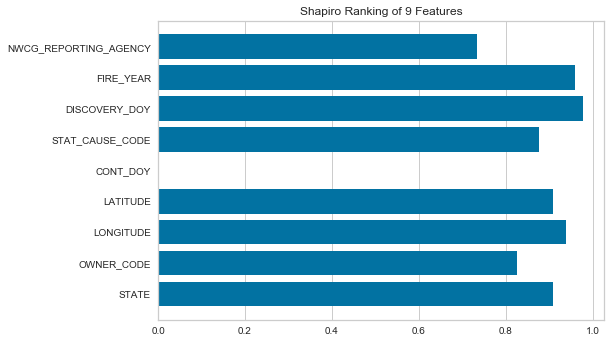

In [69]:
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show() 

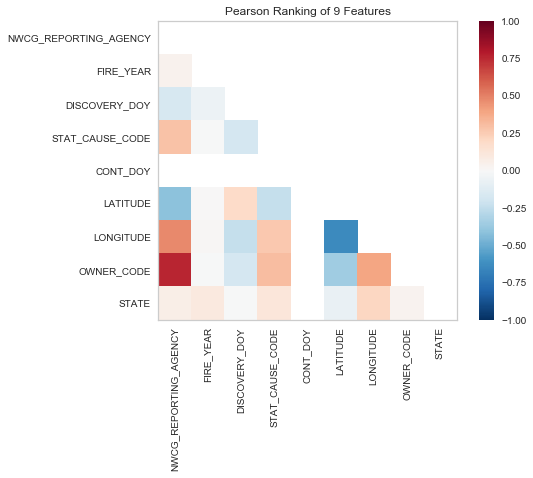

In [70]:
from yellowbrick.features import Rank2D


visualizer = Rank2D(algorithm='pearson')

visualizer.fit(X, y)           
visualizer.transform(X)        
visualizer.show()  

In [71]:
wildfires2= wildfires.sample(frac=.8, replace=False, weights=None, random_state=2)
wildfires2.reset_index(drop=True, inplace=True)

X2= wildfires[["DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","STATE"]]
y2 = wildfires["FIRE_SIZE_CLASS"]
wildfires2.shape

(43274, 12)

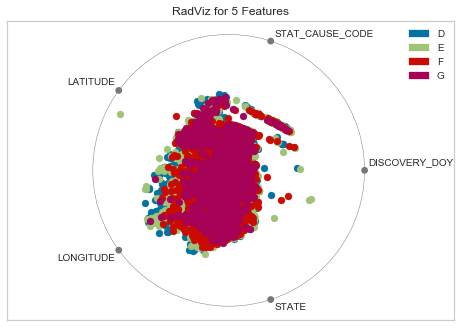

In [72]:
from yellowbrick.features import RadViz


classes = ["D", "E","F", "G"]
# Instantiate the visualizer
visualizer = RadViz(classes = classes)

visualizer.fit(X2, y2)           # Fit the data to the visualizer
visualizer.transform(X2)        # Transform the data
visualizer.show()    

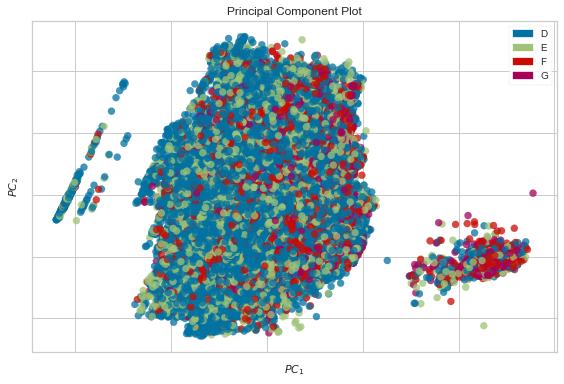

In [73]:
from yellowbrick.features import PCA

# Specify the features of interest and the target
classes = ["D", "E","F", "G"]

visualizer = PCA(scale=True, classes=classes)
visualizer.fit_transform(X2, y2)
visualizer.show()

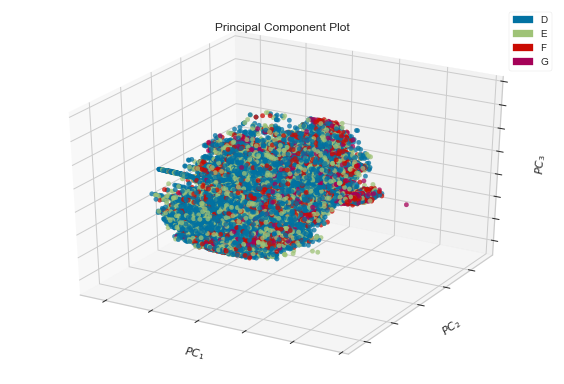

In [74]:
from yellowbrick.features import PCA


classes = ["D", "E","F", "G"]

visualizer = PCA(
    scale=True, projection=3, classes=classes
)
visualizer.fit_transform(X2, y2)
visualizer.show()

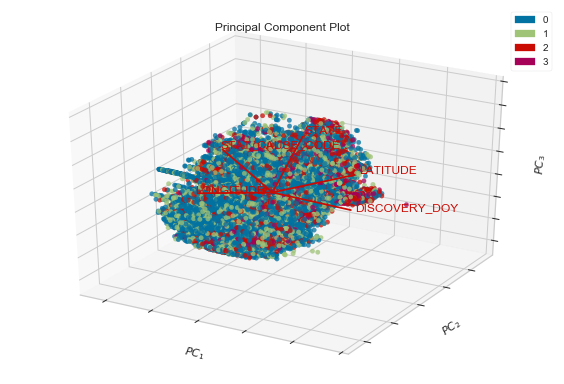

In [75]:
visualizer = PCA(scale=True, proj_features=True, projection=3)
visualizer.fit_transform(X2, y2)
visualizer.show()

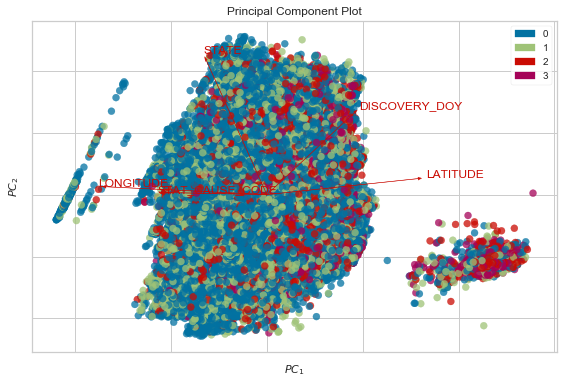

In [76]:
visualizer = PCA(scale=True, proj_features=True)
visualizer.fit_transform(X2, y2)
visualizer.show()

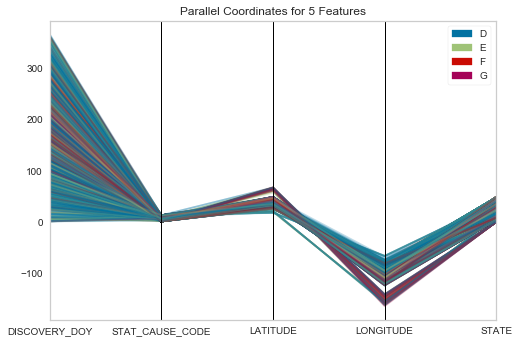

In [77]:
from yellowbrick.features import ParallelCoordinates

# Specify the features of interest and the classes of the target
features = [
    "DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","STATE"]
classes = ["D", "E","F", "G"]

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features, sample=0.05, shuffle=True
)

# Fit and transform the data to the visualizer
visualizer.fit_transform(X2,y2)

# Finalize the title and axes then display the visualization
visualizer.show()

In [78]:
# from yellowbrick.features.manifold import manifold_embedding


# # Load the regression dataset


# # Instantiate the visualizer
# manifold_embedding(X2, y2, manifold="isomap", n_neighbors=10)

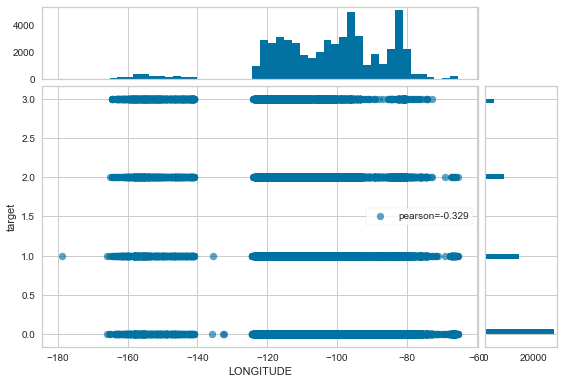

In [79]:
from yellowbrick.features import JointPlotVisualizer

# Load the dataset

# Instantiate the visualizer
visualizer = JointPlotVisualizer(columns="LONGITUDE")

visualizer.fit_transform(X2, y2)        # Fit and transform the data
visualizer.show()  

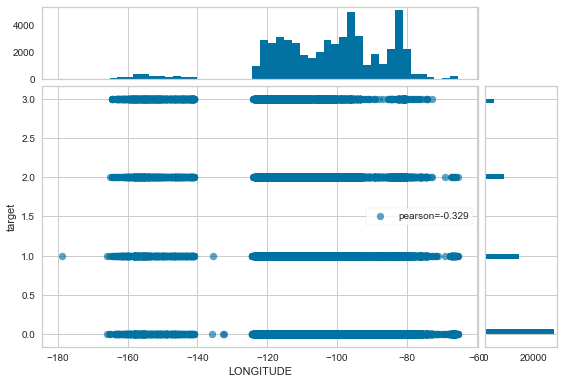

In [80]:
from yellowbrick.features import JointPlotVisualizer

# Load the dataset

# Instantiate the visualizer
visualizer = JointPlotVisualizer(columns="LONGITUDE")

visualizer.fit_transform(X, y2)        # Fit and transform the data
visualizer.show()  

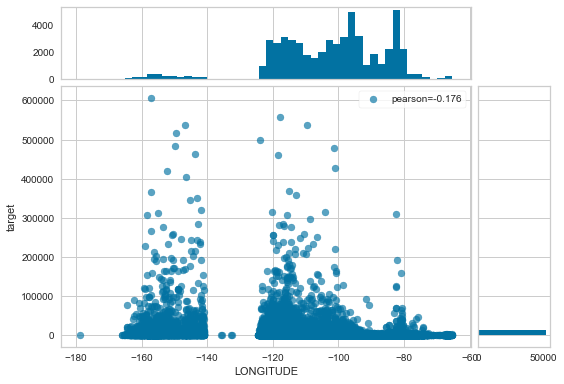

In [81]:
from yellowbrick.features import JointPlotVisualizer

# Load the dataset

# Instantiate the visualizer
visualizer = JointPlotVisualizer(columns="LONGITUDE")

visualizer.fit_transform(X, y)        # Fit and transform the data
visualizer.show()  

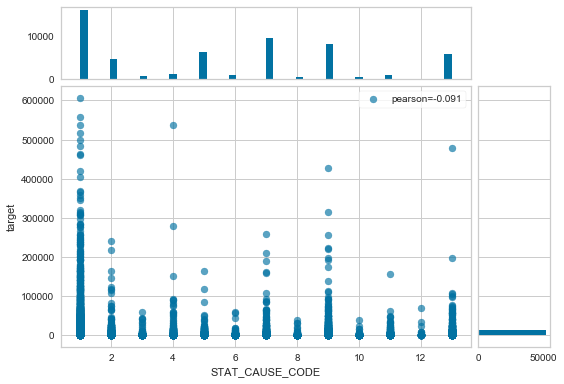

In [82]:
from yellowbrick.features import JointPlotVisualizer

# Load the dataset

# Instantiate the visualizer
visualizer = JointPlotVisualizer(columns="STAT_CAUSE_CODE")

visualizer.fit_transform(X, y)        # Fit and transform the data
visualizer.show()  

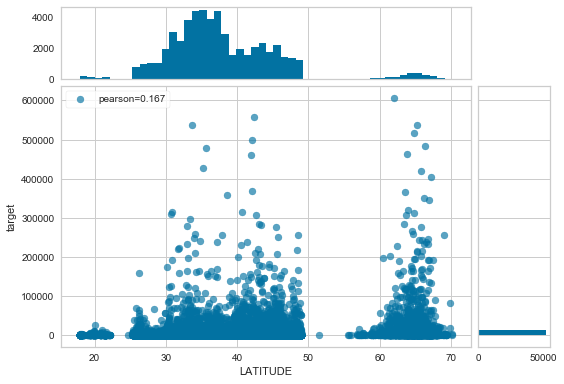

In [83]:
from yellowbrick.features import JointPlotVisualizer

# Load the dataset

# Instantiate the visualizer
visualizer = JointPlotVisualizer(columns="LATITUDE")

visualizer.fit_transform(X, y)        # Fit and transform the data
visualizer.show()  

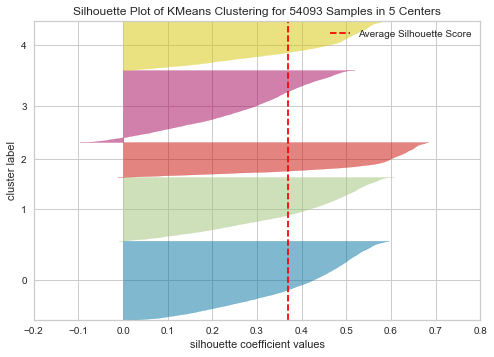

In [84]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import SilhouetteVisualizer


# Load a clustering dataset


# Specify the features to use for clustering
features = [
    "DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","STATE"]


# Instantiate the clustering model and visualizer
model = KMeans(5, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X2)        # Fit the data to the visualizer
visualizer.show()  

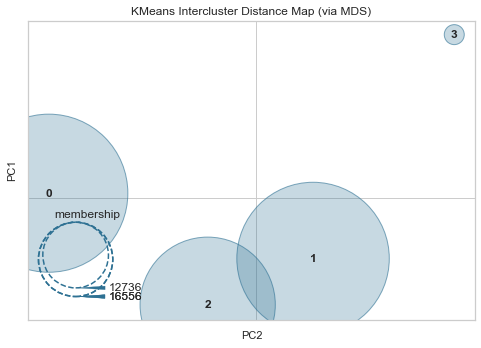

In [85]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import InterclusterDistance

# Generate synthetic dataset with 12 random clusters

# Instantiate the clustering model and visualizer
model = KMeans(4)
visualizer = InterclusterDistance(model)

visualizer.fit(X2)        # Fit the data to the visualizer
visualizer.show() 

In [86]:
intercluster_distance(MiniBatchKMeans(4, random_state=777), X2)

NameError: name 'intercluster_distance' is not defined

In [87]:

fires_table = pd.read_sql_query("SELECT * from Fires where FIRE_SIZE>= 100", con)
wildfiresall = fires_table

le = preprocessing.LabelEncoder()
le.fit(wildfiresall["STATE"].unique())
wildfires.loc[:, "STATE"] = le.transform(wildfiresall["STATE"])
le.fit(wildfiresall["NWCG_REPORTING_AGENCY"].unique())
wildfiresall.loc[:, "NWCG_REPORTING_AGENCY"] = le.transform(wildfiresall["NWCG_REPORTING_AGENCY"])
# le.fit(wildfiresall["FIRE_SIZE_CLASS"].unique())
# wildfiresall.loc[:, "FIRE_SIZE_CLASS"] = le.transform(wildfiresall["FIRE_SIZE_CLASS"])

Xall = wildfiresall['FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME']
yall = wildfiresall["FIRE_SIZE"]

visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(Xall, yall)           # Fit the data to the visualizer
visualizer.transform(Xall)        # Transform the data
visualizer.show()

KeyError: ('FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME')

In [117]:
le = preprocessing.LabelEncoder()
le.fit(wildfires["STATE"].unique())
wildfires.loc[:, "STATE"] = le.transform(wildfires["STATE"])

le.fit(wildfires["NWCG_REPORTING_AGENCY"].unique())
wildfires.loc[:, "NWCG_REPORTING_AGENCY"] = le.transform(wildfires["NWCG_REPORTING_AGENCY"])

# le.fit(wildfires["FIRE_SIZE_CLASS"].unique())
# wildfires.loc[:, "FIRE_SIZE_CLASS"] = le.transform(wildfires["FIRE_SIZE_CLASS"])
wildfires.fillna(0)
X = wildfires[["NWCG_REPORTING_AGENCY", "FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE","OWNER_CODE","STATE"]]
X2 = wildfires[["FIRE_YEAR", "DISCOVERY_DOY", "STAT_CAUSE_CODE","LATITUDE","LONGITUDE"]]
y = wildfires["FIRE_SIZE"]
y2 = wildfires["FIRE_SIZE_CLASS"]


In [118]:
from sklearn import svm
from sklearn.model_selection import train_test_split
import csv, json
import pandas as pd
# csv_name = "dataf2.csv"
# col_list = ["BIDR1","WIDR1","RR1","BIDR2","WIDR2","RR2","BIDR3","WIDR3",'RR3','BIDR4','WIDR4','RR4','BIDR5','WIDR5','RR5','BIDR6','WIDR6','RR6','BIDR7','WIDR7','RR7']
# df = pd.read_csv(csv_name, usecols=col_list)
datas = []
# with open('data.csv', newline='') as csvfile:
#     spamreader = csv.reader(csvfile, delimiter=',')
#     for row in spamreader:
#         temp = []
#         for i in row:
#             temp.append(float(i))
#         datas.append(temp)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.05, random_state=1)
clf = svm.SVR()
clf.fit(X_train, y_train)

clf2 = svm.SVC()
clf2.fit(X2_train, y2_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
p = 0
f = 0
# print(clf.predict(X_test))
# print(y_test)
for i in range(0,len(y_test)):
    if int(y_test[i])*0.9 <= int(clf.predict(X_test)[i]) and int(y_test[i])*1.1 >= int(clf.predict(X_test)[i]) :
        p+=1
        print("p")
    else:
        f+=1
print(p)
print(f)

In [119]:
from sklearn.metrics import mean_squared_error
print("Regression")
yfit = clf.predict(X_test)
score = clf.score(X_test,y_test)
print("R-squared:", score)
print("MSE:", mean_squared_error(y_test, yfit))
print("--------------------------------------")
print("Classification")
y2fit = clf2.predict(X2_test)
score2 = clf2.score(X2_test,y2_test)
print("R-squared:", score2)
print("MSE:", mean_squared_error(y2_test, y2fit))

R-squared: -0.026852014802183133
MSE: 158826661.7815396
-0.026852014802183133
R-squared: 0.5279112754158964
MSE: 1.468022181146026


In [122]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)
nn.fit(X2_train, y2_train)
ynnfit = nn.predict(X2_test)
score3 = nn.score(X2_test,y2_test)
print("R-squared:", score3)
print("MSE:", mean_squared_error(y2_test, ynnfit))

R-squared: 0.15748613678373383
MSE: 2.4262476894639557
